In [1]:
#what is SQL Agent?
#sql agent is the system that takes Natural Language as Input looks into DB Schema 
#and convert into Natural Language into appropriate SQL statement based on the result the agent
#generate Natural Language Response.

#importing modules which is used in simple RAG Project.
#below classes we used so user can interact with LLM Models.
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint #HFE class we used to hit user query and take response from it.

#below classes we used for embedding Models
from langchain_openai import OpenAIEmbeddings  #close source model
from langchain_huggingface import HuggingFaceEmbeddings #open source model


from pathlib import Path
from typing import Annotated,Optional,List,Literal,TypedDict
from dataclasses import dataclass
from loggers import logger
from Exception import CustomException
import os,sys

from langgraph.graph import StateGraph,START,END #using this class we can create Graph start or end of workflow

#if i want to add tool support to my workflow.
from langchain.tools import tool,Tool,StructuredTool

#if i want to add toolnode in my workflow 
#(toolnode means that node have list of tool here they will decide based on user query which tool need to execute)
from langgraph.prebuilt import ToolNode,tools_condition

#if i need to add memory or persistence to my workflow so that it can save the state value at every checkpoint
from langgraph.checkpoint.memory import InMemorySaver #it will save in state value to Ram memory.
from langgraph.checkpoint.sqlite import SqliteSaver

#tools_condition will  decide if tool message is present on AI response then they redirect to toolnode or end it workflow
from pydantic import BaseModel,Field,computed_field

#this class we used to change retriever object to become tool
from langchain_core.tools.retriever import create_retriever_tool

#fetching the RAG prompt from Hub.
from langchain import hub

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

import warnings as w
w.filterwarnings('ignore')

from langchain_core.messages import AIMessage,HumanMessage,AnyMessage,ToolMessage
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
'''
Flow of SQL Agent
User Question 
   ⬇
Fetch Schema from DB 
   ⬇
Inject Schema into LLM Prompt 
   ⬇
LLM Generates SQL 
   ⬇
Execute SQL on Database 
   ⬇
Fetch Result Rows 
   ⬇
LLM Converts Result → Human Answer 
   ⬇
Final Output to User

'''

'\nFlow of SQL Agent\nUser Question \n   ⬇\nFetch Schema from DB \n   ⬇\nInject Schema into LLM Prompt \n   ⬇\nLLM Generates SQL \n   ⬇\nExecute SQL on Database \n   ⬇\nFetch Result Rows \n   ⬇\nLLM Converts Result → Human Answer \n   ⬇\nFinal Output to User\n\n'

In [13]:
#groq model
model1 = ChatGroq(
    model="groq/compound-mini",
    temperature=0
)

#openai model
model2 = ChatOpenAI(
    model="gpt-3.5-turbo",temperature=0
)

#hugging face model.
llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",  
    task="text-generation",  
    
)
model3 = ChatHuggingFace(llm=llm)


emb_model = OpenAIEmbeddings(model="text-embedding-3-small")

#### How SQLAgent work ?

In [3]:
# Database Connector → SQLAlchemy, BigQuery client, etc.
# LLM Model → GPT, Claude, Gemini, etc.
# Toolkit/Wrapper → LangChain SQLDatabaseChain or LangGraph.
# Agent → Maintains context and decides whether to call DB or just answer directly.

In [4]:
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.ext.declarative import declarative_base
from langchain_core.runnables import RunnableConfig 
from sqlalchemy.orm import sessionmaker, relationship

### Sample Table Creating in sqlite Database using sqlalchemy ORM

In [5]:
DATABASE_URL = "sqlite:///example.db"

#creating Database Connection.
engine = create_engine(DATABASE_URL)

#Creates sessions to talk to DB
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
SessionLocal

sessionmaker(class_='Session', autocommit=False, bind=Engine(sqlite:///example.db), autoflush=False, expire_on_commit=True)

In [6]:
#creating an object of Base class of sqlalchemy.
Base = declarative_base()

class User(Base):
    __tablename__ = "users"
    

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    email = Column(String, unique=True, index=True)

    orders = relationship("Order", back_populates="user",)


class Food(Base):
    __tablename__ = "food"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, unique=True, index=True)
    price = Column(Float)

    orders = relationship("Order", back_populates="food")


class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True, index=True)
    food_id = Column(Integer, ForeignKey("food.id"))
    user_id = Column(Integer, ForeignKey("users.id"))

    user = relationship("User", back_populates="orders")
    food = relationship("Food", back_populates="orders")

## defining the SQL Agent

In [7]:
class AgentState(TypedDict):
    # The original question asked by the user
    question: str  

    # The SQL query generated by the agent from the question
    sql_query: str  

    # The raw result returned from executing the SQL query (as string/summary)
    query_result: str  

    # The actual rows/records fetched from the database (list of dicts/tuples)
    query_rows: list  

    # The username or identifier of the current user interacting with the agent
    current_user: str  

    # Number of attempts made to answer the question (useful for retries/debug)
    attempts: int  

    # Indicates how relevant the SQL query/result is to the original question
    relevance: str  

    # Flag showing if an error occurred while running the SQL query
    sql_error: bool  


### step:1) to get the schema of all tables exists in database

In [8]:
from sqlalchemy import text, inspect
def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    return schema

### testing to see the schema of database

In [9]:
print(get_database_schema(engine=engine))

Retrieved database schema.
Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: orders
- id: INTEGER, Primary Key
- food_id: INTEGER
- user_id: INTEGER

Table: users
- id: INTEGER, Primary Key
- name: VARCHAR
- age: INTEGER
- email: VARCHAR




### stpe:2) to get current user ids

In [10]:
#config allow usto pass the information during runtime(dont know the user_id initially so we pass dynamically)
def get_current_user(state: AgentState, config: RunnableConfig):
    print("Retrieving the current user based on user ID.")
    user_id = config["configurable"].get("current_user_id", None)
    if not user_id:
        state["current_user"] = "User not found"
        print("No user ID provided in the configuration.")
        return state

    session = SessionLocal()
    try:
        user = session.query(User).filter(User.id == int(user_id)).first()
        if user:
            state["current_user"] = user.name
            print(f"Current user set to: {state['current_user']}")
        else:
            state["current_user"] = "User not found"
            print("User not found in the database.")
    except Exception as e:
        state["current_user"] = "Error retrieving user"
        print(f"Error retrieving user: {str(e)}")
    finally:
        session.close()
    return state

### Testing function

In [12]:
config = {
    "configurable": {
        "current_user_id": 1   # dynamically passed at runtime
    }
}

state = AgentState()
get_current_user(state, config)

Retrieving the current user based on user ID.
Current user set to: Alice


{'current_user': 'Alice'}

### step:3) checking the user query is relevant to database schema or not

In [ ]:
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine) #fetching the schema from DB.
    print(f"Checking relevance of the question: {question}")
    
    system = """You are an assistant that determines whether a given question is related to the following database schema.
    
    Schema:
    {schema}

    Respond with only "relevant" or "not_relevant".
    """

    human = f"Question: {question}"
    
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    #warapping the model with structured output
    structured_llm = model2.with_structured_output(CheckRelevance)
    #forming chains to pass prompt to llm 
    relevance_checker = check_prompt | structured_llm
    #chain is runnable so we can invoke
    relevance = relevance_checker.invoke({"schema": schema, "question": question})
    #updating state or returning to state class
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

### step:4) below code block we used to generate(llm) sql query based on user question

In [15]:
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

def convert_nl_to_sql(state: AgentState, config: RunnableConfig):
    question = state["question"]
    current_user = state["current_user"]
    schema = get_database_schema(engine)
    print(f"Converting question to SQL for user '{current_user}': {question}")
    system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:

    {schema}

    The current user is '{current_user}'. Ensure that all query-related data is scoped to this user.
    Provide only the SQL query without any explanations. 
    Alias columns appropriately to match the expected keys in the result.
    For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.
    
    """
    
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    
    structured_llm = model2.with_structured_output(ConvertToSQL)
    
    sql_generator = convert_prompt | structured_llm
    
    result = sql_generator.invoke({
        "schema": schema,
        "current_user": current_user,
        "question": question
    })
    print(result)
    
    #updating state
    state["sql_query"] = result.sql_query
    print(f"Generated SQL query: {state['sql_query']}")
    return state

### step:5) executing the sql queries

In [16]:
def execute_sql(state: AgentState):
    sql_query = state["sql_query"].strip()
    session = SessionLocal()
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            if rows:
                header = ", ".join(columns)
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                print(f"Raw SQL Query Result: {state['query_rows']}")
                # Format the result for readability
                data = "; ".join([f"{row.get('food_name', row.get('name'))} for ${row.get('price', row.get('food_price'))}" for row in state["query_rows"]])
                formatted_result = f"{header}\n{data}"
            else:
                state["query_rows"] = []
                formatted_result = "No results found."
            state["query_result"] = formatted_result
            state["sql_error"] = False
            print("SQL SELECT query executed successfully.")
        else:
            session.commit()
            state["query_result"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state

### step:6) Human readable SQL queries

In [18]:
def generate_human_readable_answer(state: AgentState):
    """
    Converts SQL query results into human-readable text.
    Handles errors, SELECT queries (with/without results), and non-SELECT queries.
    """

    # Extract state variables
    sql = state.get("sql_query", "")
    result = state.get("query_result", "")
    current_user = state.get("current_user", "")
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)

    print("Generating a human-readable answer.")

    # System prompt (with placeholder)
    system_prompt = (
        "You are an assistant that converts SQL query results into clear, "
        "natural language responses without including any identifiers like order IDs. "
        "Start the response with a friendly greeting that includes the user's name: {current_user}."
    )

    # Determine which human prompt to use
    if sql_error:
        human_prompt = (
            "SQL Query: {sql}\n"
            "Result: {result}\n\n"
            "Formulate a clear and understandable error message in a single sentence, "
            "starting with 'Hello {current_user},' informing them about the issue."
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            human_prompt = (
                "SQL Query: {sql}\n"
                "Result: {result}\n\n"
                "Formulate a clear and understandable answer to the original question in a single sentence, "
                "starting with 'Hello {current_user},' and mention that there are no orders found."
            )
        else:
            human_prompt = (
                "SQL Query: {sql}\n"
                "Result: {result}\n\n"
                "Formulate a clear and understandable answer to the original question in a single sentence, "
                "starting with 'Hello {current_user},' and list each item ordered along with its price. "
                "For example: 'Hello Bob, you have ordered Lasagne for $14.0 and Spaghetti Carbonara for $15.0.'"
            )
    else:
        human_prompt = (
            "SQL Query: {sql}\n"
            "Result: {result}\n\n"
            "Formulate a clear and understandable confirmation message in a single sentence, "
            "starting with 'Hello {current_user},' confirming that your request has been successfully processed."
        )

    # Create prompt template
    generate_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_prompt)
    ])

    # Invoke the model with placeholders filled
    human_response = generate_prompt | model2 | StrOutputParser()
    answer = human_response.invoke({
        "current_user": current_user,
        "sql": sql,
        "result": result
    })

    # Update state
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state


### step:6) if question is relevant than rewrite question

In [ ]:
from pydantic import BaseModel, Field

class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: AgentState):
    """
    Rewrites the user's original question to make SQL queries more precise.
    Preserves all necessary details for accurate data retrieval.
    """
    question = state.get("question", "")
    print("Regenerating the SQL query by rewriting the question.")

    # System prompt with placeholder
    system_prompt = (
        "You are an assistant that reformulates an original question to enable more precise SQL queries. "
        "Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data."
    )

    # Human prompt with placeholder
    human_prompt = (
        "Original Question: {question}\n"
        "Reformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved."
    )

    # Create prompt template
    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_prompt)
    ])

    # Structured LLM output
    structured_llm = model2.with_structured_output(RewrittenQuestion)

    # Combine prompt and structured LLM
    rewriter = rewrite_prompt | structured_llm

    # Invoke with placeholders
    rewritten = rewriter.invoke({
        "question": question
    })

    # Update state
    state["question"] = rewritten.question
    state["attempts"] = state.get("attempts", 0) + 1

    print(f"Rewritten question: {state['question']}")
    return state


### step:7) generate funny reponse if user query is irrrelevant

In [20]:
def generate_funny_response(state: AgentState):
    question = state.get("question", "")
    
    """
    Generates a funny, playful response for questions that cannot be answered directly.
    """
    print("Generating a funny response for an unrelated question.")

    # System prompt with placeholder (future-proof)
    system_prompt = (
        "You are a charming and funny assistant who responds in a playful manner."
    )

    # Human message with placeholder
    human_message = (
        "{user_question} - I cannot help with that, but doesn't asking questions make you hungry? "
        "You can always order something delicious."
    )

    # Create prompt template
    funny_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_message)
    ])

    

    # Combine prompt and LLM
    funny_response = funny_prompt | model2 | StrOutputParser()

    # Invoke with placeholder dictionary
    message = funny_response.invoke({
        "user_question": question
    })

    # Update state
    state["query_result"] = message
    print("Generated funny response.")
    return state


### step:7) restriction applying maximum to give answer

In [21]:
def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state


### step:8) router function will route by edges

In [22]:
def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "generate_funny_response"

def check_attempts_router(state: AgentState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

def execute_sql_router(state: AgentState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

# adding nodes or edges to graph

In [23]:
workflow = StateGraph(AgentState)

workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("end_max_iterations", end_max_iterations)


In [24]:
workflow.add_edge("get_current_user", "check_relevance")

workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "generate_funny_response": "generate_funny_response",
    },
)

workflow.add_edge("convert_to_sql", "execute_sql")

workflow.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
    },
)

workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sql": "convert_to_sql",
        "max_iterations": "end_max_iterations",
    },
)


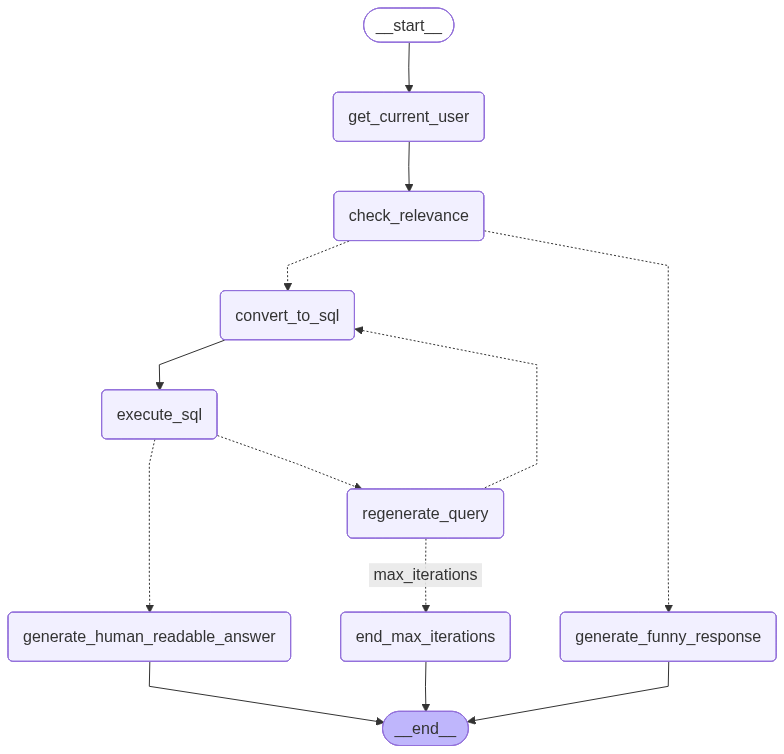

In [25]:
workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iterations", END)

workflow.set_entry_point("get_current_user")

app = workflow.compile()
app

In [26]:
fake_config = {"configurable": {"current_user_id": "2"}}
user_question_1 = "Create a new order for Spaghetti Carbonara."
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])

Retrieving the current user based on user ID.
Current user set to: Bob
Retrieved database schema.
Checking relevance of the question: Create a new order for Spaghetti Carbonara.
[2025-09-24 20:31:42,370]-INFO-1025-HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'Bob': Create a new order for Spaghetti Carbonara.
[2025-09-24 20:31:44,272]-INFO-1025-HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
sql_query="INSERT INTO orders (food_id, user_id) VALUES ((SELECT id FROM food WHERE name = 'Spaghetti Carbonara'), (SELECT id FROM users WHERE name = 'Bob'))"
Generated SQL query: INSERT INTO orders (food_id, user_id) VALUES ((SELECT id FROM food WHERE name = 'Spaghetti Carbonara'), (SELECT id FROM users WHERE name = 'Bob'))
Executing SQL query: INSERT INTO orders (food_id, user_id) VALUES ((SELECT id FROM food WHERE name = 'Spaghetti Carbon

In [27]:
user_question_3 = "Show me my orders"
result_3 = app.invoke({"question": user_question_3, "attempts": 0}, config=fake_config)
print("Result:", result_3["query_result"])

Retrieving the current user based on user ID.
Current user set to: Bob
Retrieved database schema.
Checking relevance of the question: Show me my orders
[2025-09-24 20:34:53,574]-INFO-1025-HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'Bob': Show me my orders
[2025-09-24 20:34:55,039]-INFO-1025-HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
sql_query="SELECT food.name AS food_name, food.price AS price FROM food JOIN orders ON food.id = orders.food_id JOIN users ON orders.user_id = users.id WHERE users.name = 'Bob'"
Generated SQL query: SELECT food.name AS food_name, food.price AS price FROM food JOIN orders ON food.id = orders.food_id JOIN users ON orders.user_id = users.id WHERE users.name = 'Bob'
Executing SQL query: SELECT food.name AS food_name, food.price AS price FROM food JOIN orders ON food.id = orders.food_id JOIN users

In [28]:
user_question_2 = "Tell me a joke."
result_2 = app.invoke({"question": user_question_2, "attempts": 0}, config=fake_config)
print("Result:", result_2["query_result"])

Retrieving the current user based on user ID.
Current user set to: Bob
Retrieved database schema.
Checking relevance of the question: Tell me a joke.
[2025-09-24 20:35:15,740]-INFO-1025-HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Relevance determined: not_relevant
Generating a funny response for an unrelated question.
[2025-09-24 20:35:16,593]-INFO-1025-HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Generated funny response.
Result: Why did the scarecrow win an award? Because he was outstanding in his field! If you need more jokes, just let me know!
